In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import sys
import yaml
import argparse

src_path = os.path.abspath('../../src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from _surrogate_potential_datasets import DNetPointcloudDataset
from _archs_surrogate_potential import standard_4_layer_potential_net
from _losses_surrogate_potential import (
    eikonal_loss, data_loss, gradient_normal_matching_loss, 
    directional_gradient_loss, normal_consistency_loss
)
from feature_maps import RecenterBondLayer, featurizer_carbons
from _dnet_architectures import standard_4_layer_dnet_tanh_encoder, standard_4_layer_dnet_tanh_encoder_3D


# Load config and diffusion net

In [78]:
config_path = 'config.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

    # --- Configuration ---
    DEVICE = torch.device(config['training_params']['device'])
    DATA_PATH = config['paths']['data_path']
    DNET_MODEL_PATH = config['paths']['dnet_model_path']
    SAVE_PATH = config['paths']['save_path']
    
    BATCH_SIZE = config['training_params']['batch_size']
    NUM_EPOCHS = config['training_params']['num_epochs']
    LR = config['training_params']['lr']
    
    # Loss weights
    DATA_WEIGHT = config['training_params']['data_weight']
    EIKONAL_WEIGHT = config['training_params']['eikonal_weight']
    GRADIENT_WEIGHT = config['training_params']['gradient_matching_weight']
    
    # Gradient matching parameters
    GRADIENT_LOSS_TYPE = config['training_params']['gradient_loss_type']
    NORMALIZE_GRADIENTS = config['training_params']['normalize_gradients']
    
    # Normal computation parameters
    NORMAL_PARAMS = config['normal_params']

    # --- Load Data ---
    data_npz = np.load(DATA_PATH)
    subsample_rate = 10
    raw_data = data_npz['data'][::subsample_rate]  # Use carbon-only data
    dihedrals = data_npz['dihedrals'][::subsample_rate]
    
    # --- Feature Map and D-Net ---
    recenter_map = RecenterBondLayer(atom_ind=[1, 2], batch_mode=True)
    # feature_map = featurizer_carbons(recenter_map)
    feature_map = recenter_map
    
    dnet_model_base = standard_4_layer_dnet_tanh_encoder(
        input_dim=config['model_params']['dnet']['input_dim'],
        encoder_dim=config['model_params']['dnet']['encoder_dim']
    )
    dnet_model_base.load_state_dict(torch.load(DNET_MODEL_PATH, map_location=DEVICE))
    
    dnet_model = standard_4_layer_dnet_tanh_encoder_3D(dnet_model_base)
    dnet_model.to(DEVICE)
    dnet_model.eval()

# Get datasets and dataloader

In [82]:
NORMAL_PARAMS['radius'] = 1.0
NORMAL_PARAMS['max_neighbors'] = 1000


In [83]:
# --- Datasets and Dataloaders ---
# Create dataset with normal computation if enabled
compute_normals = NORMAL_PARAMS['compute_normals']
normal_params = {k: v for k, v in NORMAL_PARAMS.items() if k != 'compute_normals'}

on_manifold_dataset = DNetPointcloudDataset(
    raw_data, feature_map, dnet_model, 
    compute_normals=compute_normals,
    normal_params=normal_params if compute_normals else None
)
on_manifold_loader = DataLoader(on_manifold_dataset, batch_size=BATCH_SIZE, shuffle=True)

Computing normals for 3D point cloud...
Computing normals for 10000 points in 3D space
Computing 3D normals using Open3D with radius=1.0, max_neighbors=1000
Computing 3D normals using Open3D with radius=1.0, max_neighbors=1000
Center of mass: [ 0.00600282 -0.02993365  0.03877629]
Normal lengths - mean: 1.000000, std: 0.000000
Computed 10000 3D normals


Let's see the data

In [84]:
normals = on_manifold_dataset.normals.detach().numpy()
pointcloud = on_manifold_dataset.point_cloud.detach().numpy()

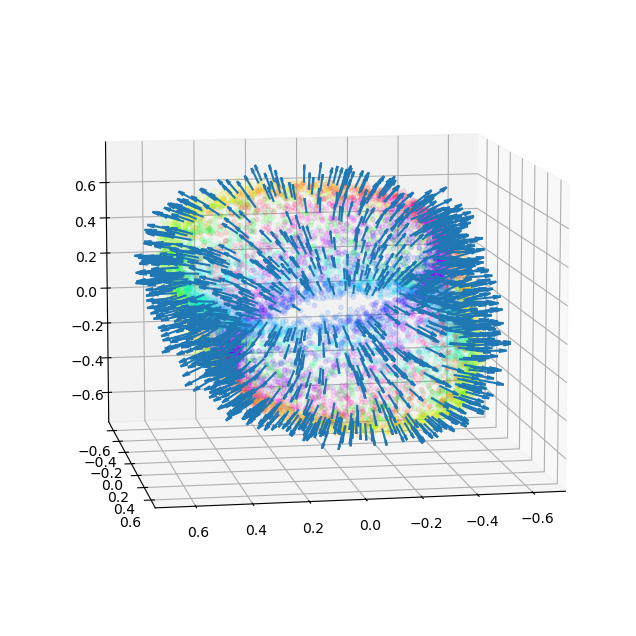

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointcloud[:, 0], \
    pointcloud[:, 1], \
    pointcloud[:, 2], c=dihedrals, alpha=0.1, s=10, cmap='hsv')
ax.view_init(elev=10, azim=80)
ax.quiver(pointcloud[::10, 0], \
    pointcloud[::10, 1], \
    pointcloud[::10, 2], \
    1e-1*normals[::10,0], 
    1e-1*normals[::10,1], 
    1e-1*normals[::10,2])
plt.show()


There is a hole in the data so we are good. 

# Architecture, optimizers

In [86]:
# --- Surrogate Potential Model ---
input_dim = on_manifold_dataset.point_cloud.shape[1]
potential_model = standard_4_layer_potential_net(
    input_dim=input_dim,
    output_dim=config['model_params']['potential']['output_dim']
)
potential_model.to(DEVICE)

optimizer = optim.Adam(potential_model.parameters(), lr=LR)

# --- Training Loop ---
print(f"Training with gradient matching: {compute_normals}")
print(f"Gradient loss type: {GRADIENT_LOSS_TYPE}")
print(f"Loss weights - Data: {DATA_WEIGHT}, Eikonal: {EIKONAL_WEIGHT}, Gradient: {GRADIENT_WEIGHT}")
 

Training with gradient matching: True
Gradient loss type: mse
Loss weights - Data: 1.0, Eikonal: 10.0, Gradient: 5.0


# Training

In [87]:
for epoch in range(NUM_EPOCHS):
        potential_model.train()
        total_loss = 0.0
        total_data_loss = 0.0
        total_eikonal_loss = 0.0
        total_gradient_loss = 0.0
        
        for batch_data in on_manifold_loader:
            optimizer.zero_grad()
            
            # Unpack batch data (depends on whether normals are computed)
            if compute_normals:
                _, on_manifold_points, normals = batch_data
                normals = normals.to(DEVICE)
            else:
                _, on_manifold_points = batch_data
                normals = None
            
            on_manifold_points = on_manifold_points.to(DEVICE)
            on_manifold_points.requires_grad_(True)
            
            predicted_potential = potential_model(on_manifold_points)
            target_potential = torch.zeros_like(predicted_potential)
            
            # Compute individual losses
            d_loss = data_loss(predicted_potential, target_potential)
            e_loss = eikonal_loss(on_manifold_points, predicted_potential)
            
            # Initialize total loss
            loss = DATA_WEIGHT * d_loss + EIKONAL_WEIGHT * e_loss
            
            # Add gradient matching loss if normals are available
            g_loss = 0.0
            if compute_normals and normals is not None:
                if GRADIENT_LOSS_TYPE == "cosine":
                    g_loss = gradient_normal_matching_loss(
                        on_manifold_points, predicted_potential, normals, 
                        loss_type='cosine', normalize_gradients=NORMALIZE_GRADIENTS
                    )
                elif GRADIENT_LOSS_TYPE == "mse":
                    g_loss = gradient_normal_matching_loss(
                        on_manifold_points, predicted_potential, normals, 
                        loss_type='mse', normalize_gradients=NORMALIZE_GRADIENTS
                    )
                elif GRADIENT_LOSS_TYPE == "combined":
                    g_loss = gradient_normal_matching_loss(
                        on_manifold_points, predicted_potential, normals, 
                        loss_type='combined', normalize_gradients=NORMALIZE_GRADIENTS
                    )
                elif GRADIENT_LOSS_TYPE == "directional":
                    g_loss = directional_gradient_loss(
                        on_manifold_points, predicted_potential, normals
                    )
                elif GRADIENT_LOSS_TYPE == "consistency":
                    g_loss = normal_consistency_loss(
                        on_manifold_points, predicted_potential, normals,
                        lambda_eikonal=1.0, lambda_alignment=1.0
                    )
                    # For consistency loss, don't add separate eikonal loss
                    loss = DATA_WEIGHT * d_loss + GRADIENT_WEIGHT * g_loss
                else:
                    raise ValueError(f"Unknown gradient loss type: {GRADIENT_LOSS_TYPE}")
                
                # Add gradient loss (except for consistency which handles eikonal internally)
                if GRADIENT_LOSS_TYPE != "consistency":
                    loss = loss + GRADIENT_WEIGHT * g_loss
            
            loss.backward()
            optimizer.step()
            
            # Accumulate losses for reporting
            total_loss += loss.item()
            total_data_loss += d_loss.item()
            total_eikonal_loss += e_loss.item()
            if compute_normals and normals is not None:
                total_gradient_loss += g_loss.item() if isinstance(g_loss, torch.Tensor) else g_loss
        
        # Print epoch statistics
        avg_total = total_loss / len(on_manifold_loader)
        avg_data = total_data_loss / len(on_manifold_loader)
        avg_eikonal = total_eikonal_loss / len(on_manifold_loader)
        
        if compute_normals:
            avg_gradient = total_gradient_loss / len(on_manifold_loader)
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Total: {avg_total:.6f}, "
                  f"Data: {avg_data:.6f}, Eikonal: {avg_eikonal:.6f}, "
                  f"Gradient: {avg_gradient:.6f}")
        else:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Total: {avg_total:.6f}, "
                  f"Data: {avg_data:.6f}, Eikonal: {avg_eikonal:.6f}")

Epoch 1/100 - Total: 10.092146, Data: 0.004223, Eikonal: 0.656275, Gradient: 0.705036
Epoch 2/100 - Total: 8.612763, Data: 0.010127, Eikonal: 0.508479, Gradient: 0.703570
Epoch 3/100 - Total: 6.995717, Data: 0.021737, Eikonal: 0.346443, Gradient: 0.701909
Epoch 4/100 - Total: 5.445012, Data: 0.042418, Eikonal: 0.189431, Gradient: 0.701657
Epoch 5/100 - Total: 4.315199, Data: 0.071975, Eikonal: 0.074136, Gradient: 0.700373
Epoch 6/100 - Total: 3.808868, Data: 0.102366, Eikonal: 0.022186, Gradient: 0.696929
Epoch 7/100 - Total: 3.673179, Data: 0.117942, Eikonal: 0.009624, Gradient: 0.691799
Epoch 8/100 - Total: 3.605855, Data: 0.118570, Eikonal: 0.006080, Gradient: 0.685296
Epoch 9/100 - Total: 3.544316, Data: 0.116161, Eikonal: 0.004386, Gradient: 0.676859
Epoch 10/100 - Total: 3.495902, Data: 0.114706, Eikonal: 0.003305, Gradient: 0.669630
Epoch 11/100 - Total: 3.437504, Data: 0.113793, Eikonal: 0.002546, Gradient: 0.659650
Epoch 12/100 - Total: 3.388443, Data: 0.112699, Eikonal: 0.002

# Evaluate

In [88]:
# map the data forward through the surrogate potential model
inputs = on_manifold_dataset.point_cloud.requires_grad_(True)
mapped_data = potential_model(inputs).squeeze()

In [ ]:
grads = torch.autograd.grad(mapped_data.sum(), inputs, create_graph=True)[0]
gg = grads.detach().numpy()
renormalized_grads = gg@np.diag((1/np.linalg.norm(gg, axis=0)))

In [91]:
train_data_psi = inputs.detach().numpy()
true_normals = on_manifold_dataset.normals.detach().numpy()

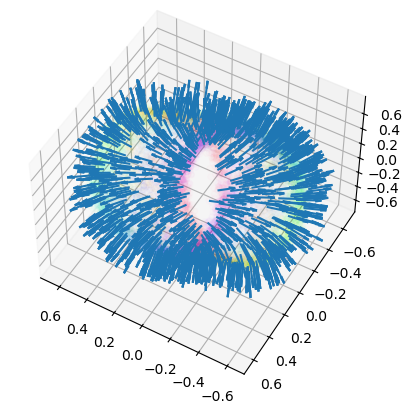

In [92]:
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(train_data_psi[::10,0], \
          train_data_psi[::10,1], \
          train_data_psi[::10,2], \
          1e1*renormalized_grads[::10,0], 
          1e1*renormalized_grads[::10,1], 
          1e1*renormalized_grads[::10,2])
ax.scatter(train_data_psi[:,0], train_data_psi[:,1], train_data_psi[:,2],\
           c=dihedrals, cmap='hsv', alpha=0.01)
# ax.set_xlim((-0.5,0.5))
# ax.set_ylim((-0.5,0.5))
# ax.set_zlim((-0.5,0.5))
ax.view_init(elev=50, azim=120, roll=0)